# Wasserstein GAN with Gradient Penalty (WGAN-GP)

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes,
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [2]:
# Generator and Noise


# Generator
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
    # z_dim = noise vector
    # im_chan = number of channels in input image
    # hidden_dim = hidden image dimentions
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        self.make_gen_block(z_dim, hidden_dim * 4),
        self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        self.make_gen_block(hidden_dim * 2, hidden_dim),
        self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),

    )

  def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.ReLU(inplace=True)
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.Tanh()
      )
  def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

  def forward(self, noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)


  def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)


In [3]:
# Noise
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [4]:
# Critic

class Critic(nn.Module):
  def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

  def make_crit_block(self,input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.LeakyReLU(0.2, inplace=True),
          )
    else:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
      )

  def forward(self, image):
    crit_pred = self.crit(image)
    return crit_pred.view(len(crit_pred), -1)



In [5]:
# Trianing


n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cpu'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [6]:
# Weights Init

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


In [7]:
# Gradient Penalty
def get_gradient(crit, real, fake, epsilon):
  # Mix the images together
  mixed_images = real * epsilon + fake * (1 - epsilon)

  # Calculate the critic's scores on the mixed images
  mixed_scores = crit(mixed_images)

  # Take the gradient of the scores with respect to the images
  gradient = torch.autograd.grad(
      inputs=mixed_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores),
      create_graph=True,
      retain_graph=True,
  )[0]

  return gradient

# Aplying the Gradient
def gradient_penalty(gradient):

    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty


In [8]:
# Calculate the Loss for the Generator
def get_gen_loss(crit_fake_pred):
    gen_loss = -crit_fake_pred.mean()
    return gen_loss

In [9]:
# Calculate the Loss for the Critic
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):

    crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + c_lambda * gp
    return crit_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: -25.711294243945943, critic loss: 1.6110894038677217


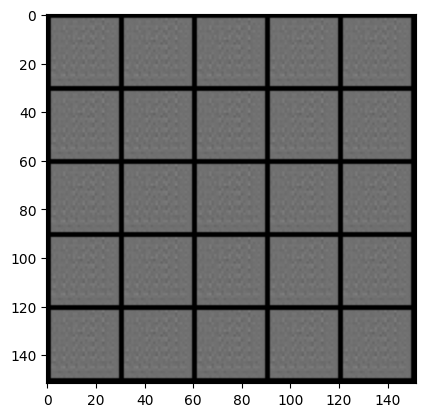

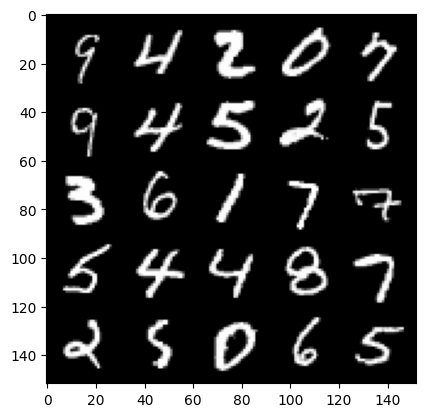

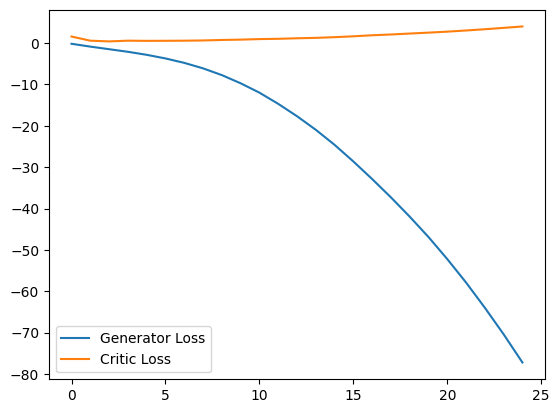

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: -204.06464848327636, critic loss: 9.96908261489868


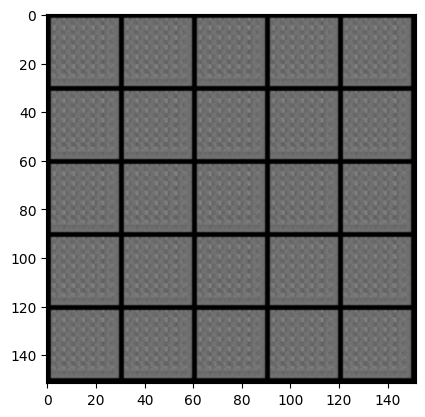

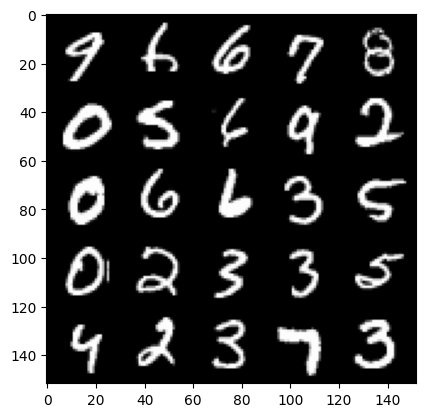

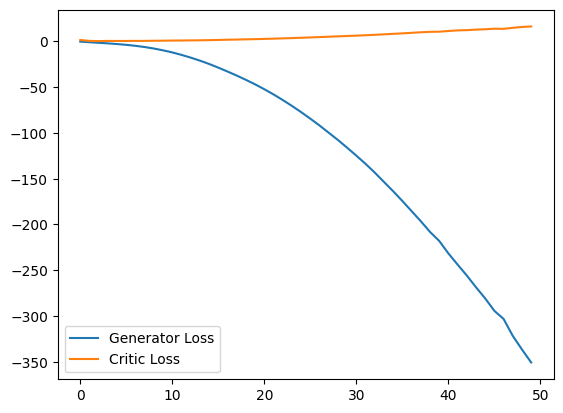

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: -564.8303834838867, critic loss: 27.48969747619629


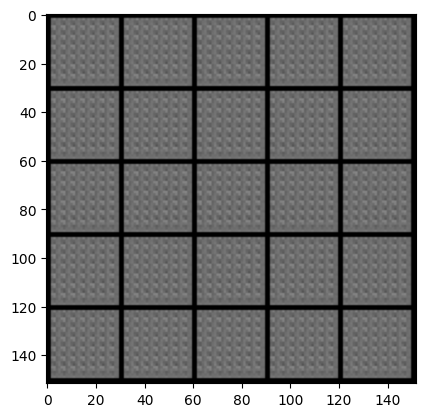

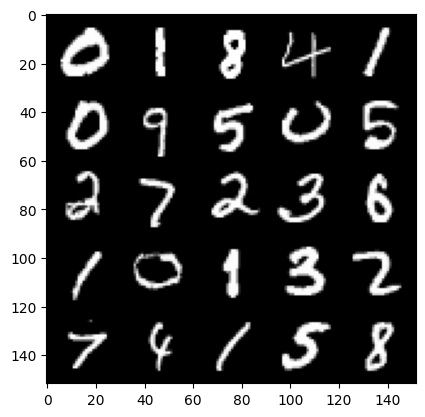

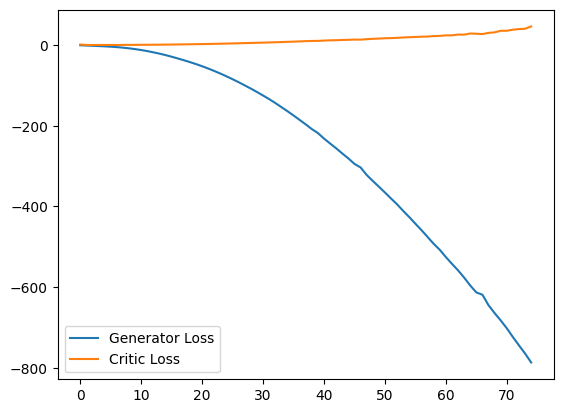

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: -1063.3482338867188, critic loss: 56.791913171386774


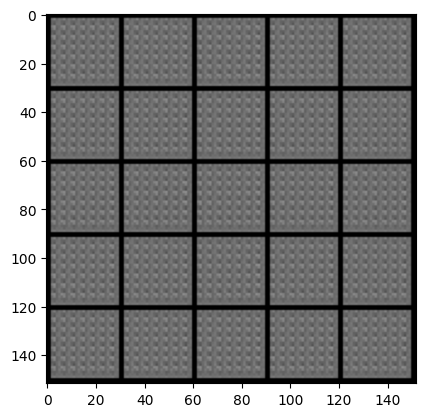

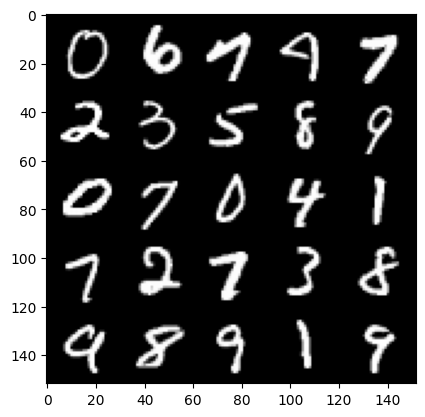

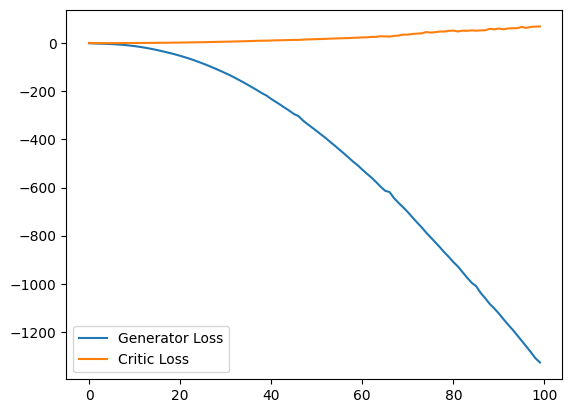

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: -1663.0179899902344, critic loss: 93.62772374267577


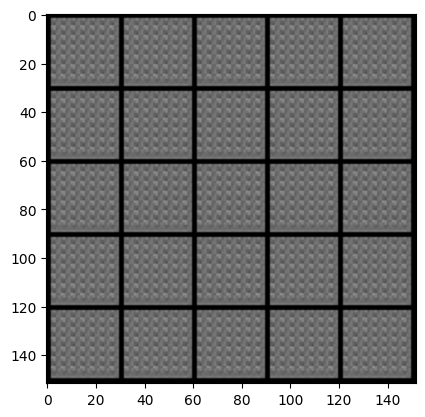

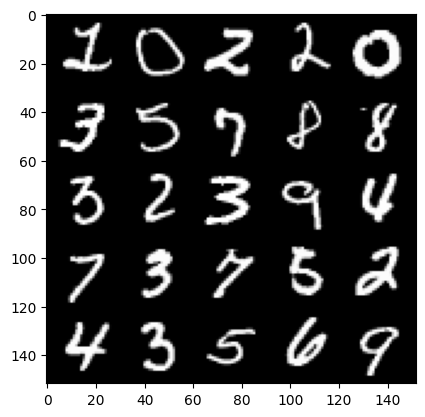

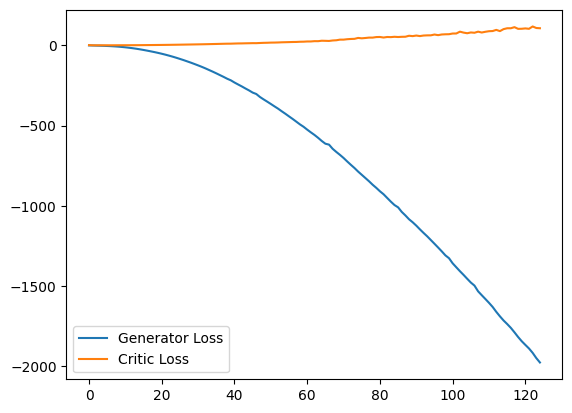

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: -2331.6855183105467, critic loss: 118.99692065429686


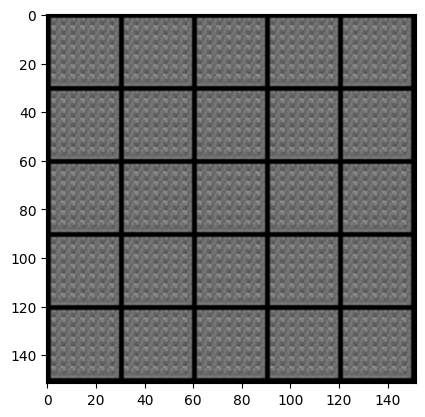

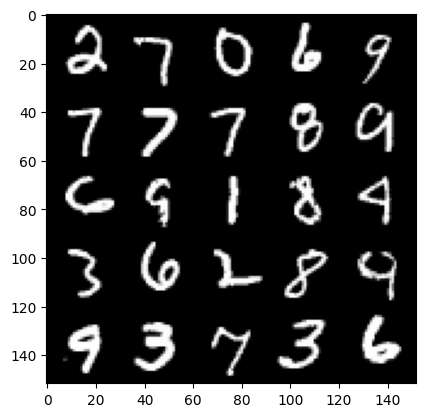

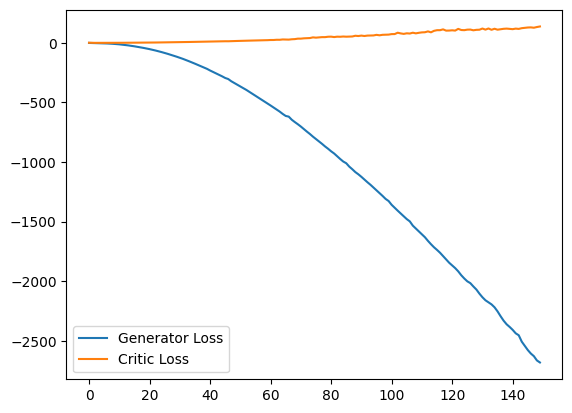

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: -3121.604748046875, critic loss: 177.9834677734375


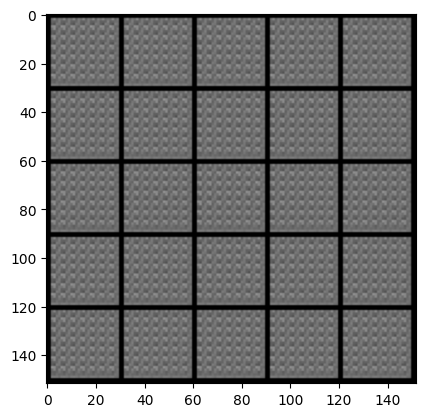

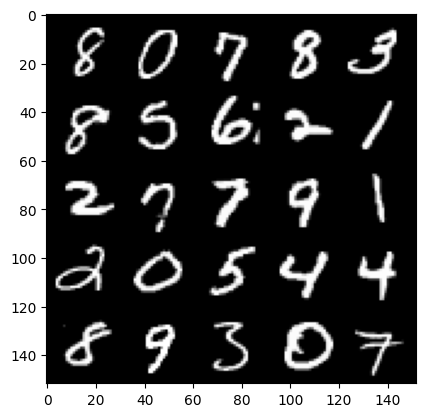

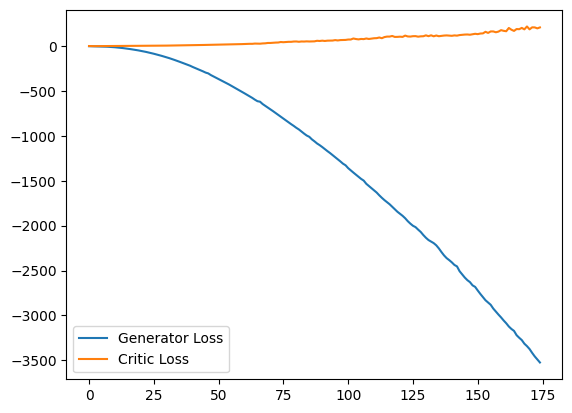

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: -3945.3678139648437, critic loss: 236.8323389160157


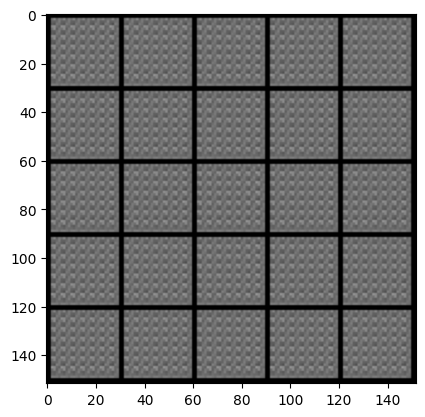

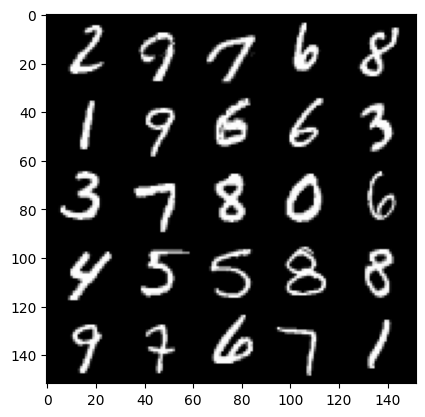

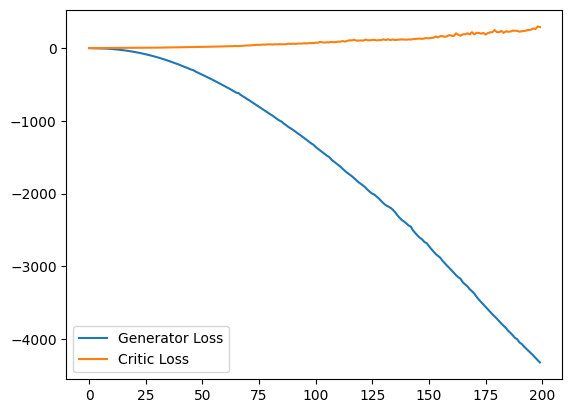

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: -4712.286922851563, critic loss: 281.1798042480466


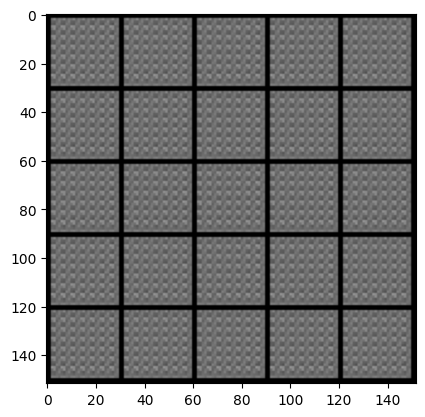

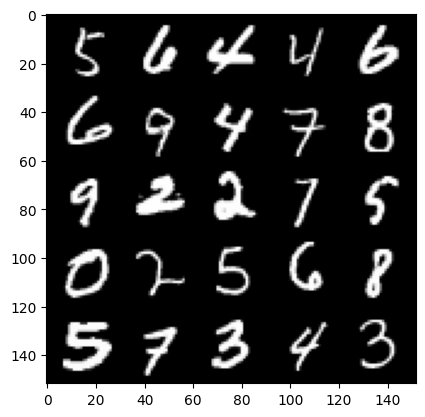

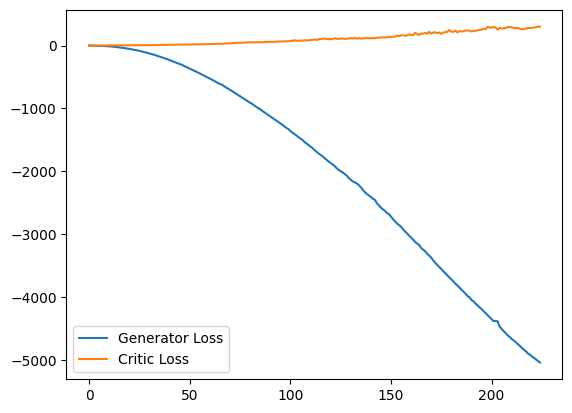

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: -5402.9862109375, critic loss: 291.08000336914034


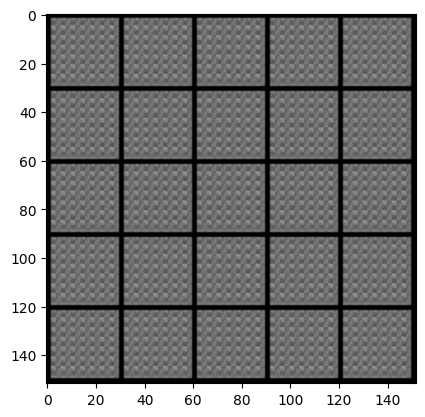

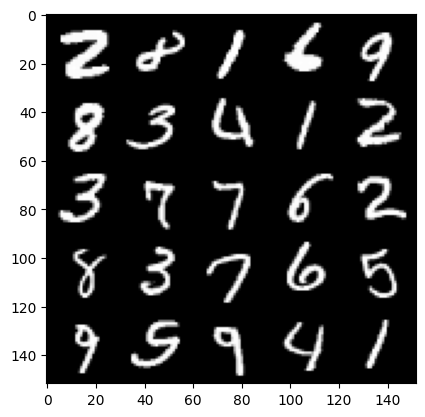

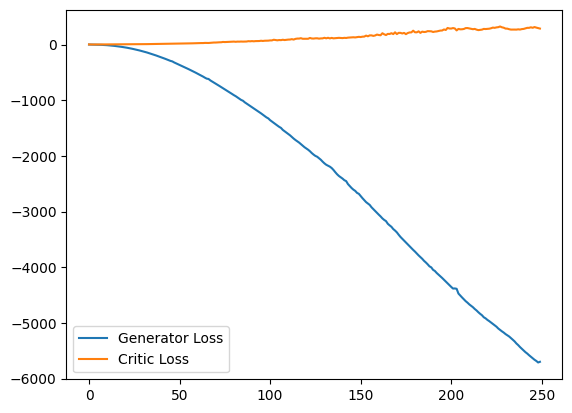

In [ ]:
# Putting It All Together

import matplotlib.pyplot as plt
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0

        # Generate Fake Images and Compute Critic Loss
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        crit_fake_pred = crit(fake.detach())
        crit_real_pred = crit(real)

        # Gradient Penalty
        crit_fake_pred = crit(fake.detach())
        epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
        gradient = get_gradient(crit, real, fake.detach(), epsilon)
        gp = gradient_penalty(gradient)

        # Calculate Critic Loss and Backpropagate
        crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)
        mean_iteration_critic_loss += crit_loss.item() / crit_repeats
        crit_loss.backward(retain_graph=True)
        crit_opt.step()

        # Track Critic Loss
        critic_losses += [mean_iteration_critic_loss]

        # Training the Generator (G)
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()
        gen_opt.step()

        # Track Generator Loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1





